# 1. Imports

In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook
import soundfile as sf
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LSTM, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, Adamax

sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 2. Data Collection

In [4]:
RAVDESS = "./data/ravdess-emotional-speech-audio/"
CREMA = "./data/cremad/"
TESS = "./data/toronto-emotional-speech-set-tess/"
SAVEE = "./data/surrey-audiovisual-expressed-emotion-savee/"

## 2.1. Ravdess dataframe

In [5]:
ravdess_actors_list = os.listdir(RAVDESS)
audio_emotion = []
audio_path = []
audio_gender = []
audio_intensity = []
durations = []

for file in ravdess_actors_list:
    actor = os.listdir(os.path.join(RAVDESS,file))
    for audio in actor:
        list_audio = audio.split('.')[0] # splitting by the '.' into '**-**-**' . 'wav' and grab the first element
        list_audio = list_audio.split('-') # splitting by the dash
        gender_code = int(list_audio[6])
        
        audio_emotion.append(int(list_audio[2])) # the third element describes the emotion class
        audio_gender.append('female' if gender_code & 1 == 0 else 'male') # the sixth element describes the voice gender 
        audio_intensity.append('normal' if int(list_audio[3]) == 1 else 'high')
        audio_path.append(os.path.join(RAVDESS,file,audio))
        
        audio, sr = librosa.load(os.path.join(RAVDESS,file,audio))
        durations.append(librosa.get_duration(y=audio, sr=sr))

ravdess_df = pd.DataFrame({'emotions': audio_emotion, 'genders': audio_gender, 'audio_intensity': audio_intensity, 'audio_path': audio_path, 'duration':durations})

# Mapping the values to emotions
emotion_dict = {
    1: 'neutral',
    2: 'neutral', # originally - - > 'calm'
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprised',
}

# Replace the values in the column with emotions
ravdess_df['emotions'] = ravdess_df['emotions'] .replace(emotion_dict)
ravdess_df['dataset'] = 'ravdess'
ravdess_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.303311,ravdess
1,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.336689,ravdess
2,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.269932,ravdess
3,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.169841,ravdess
4,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.536871,ravdess


## 2.2. Crema dataframe

In [6]:
crema_list = os.listdir(CREMA)
audio_emotion = []
audio_path = []
audio_intensity = []
gender_list = []
durations = []

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

emotion_dict = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

intensity_dict = {
    'XX' : 'normal',
    'X' : 'normal',
    'LO' : 'low',
    'MD' : 'normal',
    'HI': 'high'
}

for audio in crema_list:
    list_audio = audio.split('.')[0] # splitting by the '.' into '**-**-**' . 'wav' and grab the first element
    list_audio = list_audio.split('_') # splitting by the underline
    audio_emotion.append(list_audio[2])
    audio_intensity.append(list_audio[3])
    audio_path.append(os.path.join(CREMA,audio))
    gender_list.append('female' if list_audio[0] in female_id_list else 'male')
    
    audio, sr = librosa.load(os.path.join(CREMA,audio))
    durations.append(librosa.get_duration(y=audio, sr=sr))
    
crema_df = pd.DataFrame({'emotions': audio_emotion, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': audio_path, 'duration':durations})
crema_df['emotions'] = crema_df['emotions'].replace(emotion_dict)
crema_df['audio_intensity'] = crema_df['audio_intensity'].replace(intensity_dict)
crema_df['dataset'] = 'crema'
crema_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,angry,male,normal,./data/cremad/1001_DFA_ANG_XX.wav,2.275601,crema
1,disgust,male,normal,./data/cremad/1001_DFA_DIS_XX.wav,2.335692,crema
2,fear,male,normal,./data/cremad/1001_DFA_FEA_XX.wav,2.168844,crema
3,happy,male,normal,./data/cremad/1001_DFA_HAP_XX.wav,1.868526,crema
4,neutral,male,normal,./data/cremad/1001_DFA_NEU_XX.wav,2.035420,crema


## 2.3. TESS dataframe

In [7]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 
audio_intensity = []
durations = []

emotion_dict = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'ps'     : 'surprised',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        path_list.append(os.path.join(TESS,directory,audio_file))
        gender_list.append('female') # female only dataset
        audio_intensity.append('normal') # normal only dataset
        emotion_list.append(part.split('_')[2])
        
        audio, sr = librosa.load(os.path.join(TESS,directory,audio_file))
        durations.append(librosa.get_duration(y=audio, sr=sr))
            
tess_df = pd.DataFrame({'emotions': emotion_list, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': path_list, 'duration':durations})
tess_df['emotions'] = tess_df['emotions'].replace(emotion_dict)
tess_df['dataset'] = 'tess'
tess_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.539048,tess
1,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.616644,tess
2,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.542041,tess
3,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.606893,tess
4,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.395193,tess


## 2.3. SAVEE dataframe

In [8]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []
audio_intensity = []
durations = []

emotion_dict = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust',
    'su' : 'surprised'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    path_list.append(os.path.join(SAVEE,audio_file))
    gender_list.append('male') # male only dataset
    emotion_list.append(part[:-6])
    audio_intensity.append('normal') # normal only dataset
    
    audio, sr = librosa.load(os.path.join(SAVEE,audio_file))
    durations.append(librosa.get_duration(y=audio, sr=sr))
        
savee_df = pd.DataFrame({'emotions': emotion_list, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': path_list,'duration':durations})
savee_df['emotions'] = savee_df['emotions'].replace(emotion_dict)
savee_df['dataset'] = 'savee'

savee_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.647800,savee
1,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.438141,savee
2,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.075510,savee
3,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.725351,savee
4,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.997914,savee


In [9]:
merged_df = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis=0)
merged_df.reset_index(inplace=True, drop=True)
merged_df.to_csv('merged_df.csv',index=False)
merged_df

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.303311,ravdess
1,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.336689,ravdess
2,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.269932,ravdess
3,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.169841,ravdess
4,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.536871,ravdess
...,...,...,...,...,...,...
12157,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.014059,savee
12158,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.904263,savee
12159,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.532381,savee
12160,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,5.267619,savee


# 3. EDA

## 3.1. Exploring the data

Text(0.5, 1.0, 'Distribution of Emotions')

<Figure size 1000x600 with 0 Axes>

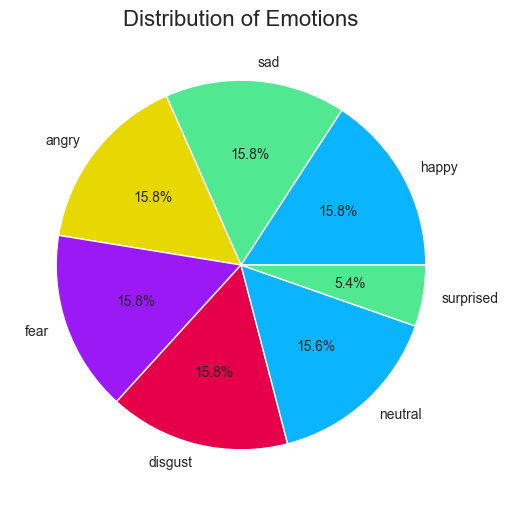

In [10]:
plt.figure(figsize=(10,6))
emotion_percent = merged_df['emotions'].value_counts(normalize=True) * 100

# Set a threshold for small percentage slices
threshold = 5

# Identify emotions below the threshold
small_emotions = emotion_percent[emotion_percent < threshold]

# Create a list of explode values
explode = [0.1 if emotion in small_emotions else 0 for emotion in emotion_percent.index]

# Set the figure size
plt.figure(figsize=(10, 6))

# Define a custom color palette
color_palette = ["#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#e60049"] 

# Create the pie chart with explode values
plt.pie(emotion_percent, labels=emotion_percent.index, autopct='%1.1f%%', colors=color_palette, explode=explode)

# Set the title
plt.title('Distribution of Emotions', size=16)

The pie chart represents the distribution of emotion types in the dataset. <br>
It is evident that apart from the surprised tone with 5.4% , the other types of tones are around 14-16%. <br>
Worth mentioning that the tone 'calm' with its 1.6% distribution in the dataset, was merged with the neutral tone.

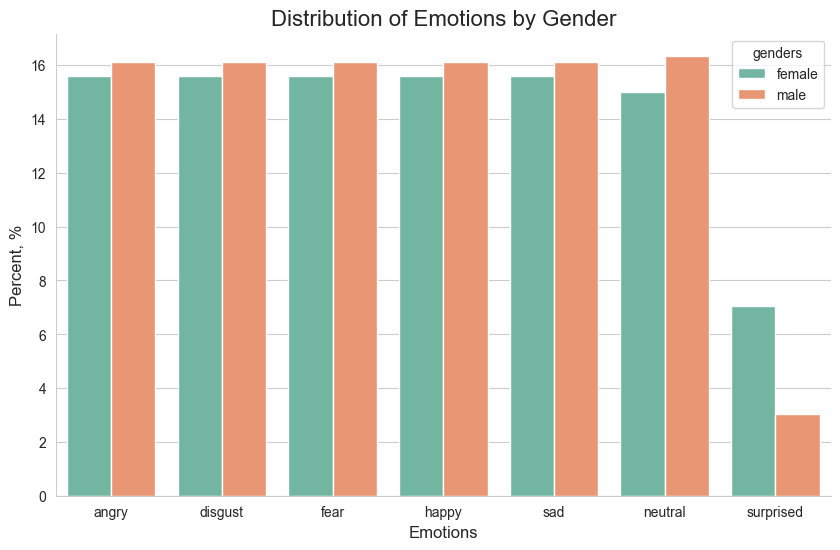

In [11]:
# Calculate the percentage of each emotion by gender
emotions_by_gender = merged_df.groupby('genders')['emotions'].value_counts(normalize=True) * 100

# Reset the index to convert the result into a DataFrame
emotions_by_gender = emotions_by_gender.reset_index(name='percentage')

plt.figure(figsize=(10,6))

sns.barplot(emotions_by_gender, x='emotions', y='percentage', hue='genders', palette='Set2')

plt.title('Distribution of Emotions by Gender', size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Percent, %', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() # Remove the top and right spines

The distribution of emotions in the entire dataset by the gender is relatively uniform.

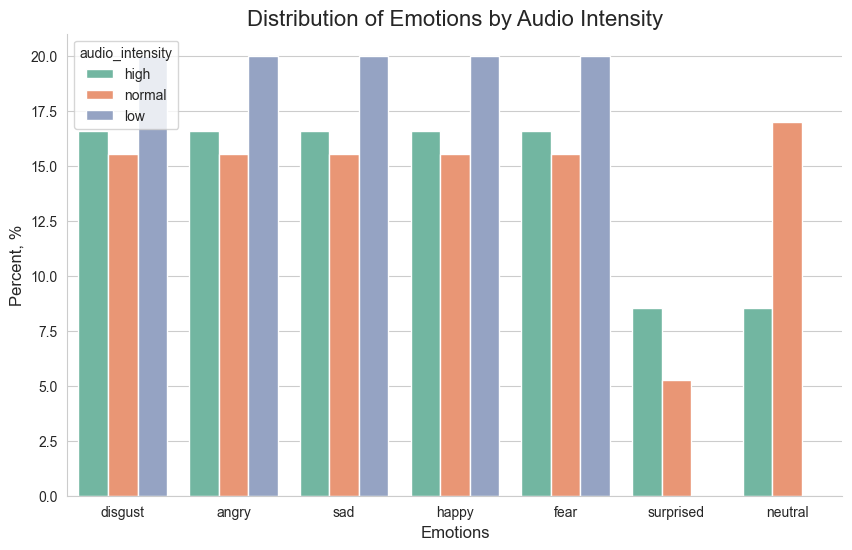

In [12]:
# Calculate the percentage of each emotion by gender
emotions_by_gender = merged_df.groupby('audio_intensity')['emotions'].value_counts(normalize=True) * 100

# Reset the index to convert the result into a DataFrame
emotions_by_gender = emotions_by_gender.reset_index(name='percentage')

plt.figure(figsize=(10,6))

sns.barplot(emotions_by_gender, x='emotions', y='percentage', hue='audio_intensity', hue_order=['high', 'normal', 'low'], palette='Set2')

plt.title('Distribution of Emotions by Audio Intensity', size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Percent, %', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() # Remove the top and right spines

The audio intensity distribution is divided by high, normal, and low. Neutral and surprised tones have only two intensities, normal and high. <br>
The total distribution is uniform between all the modes of the tone intensity (15%-20%), where only in neutral tone there is a higher percentage of normal intensity. 

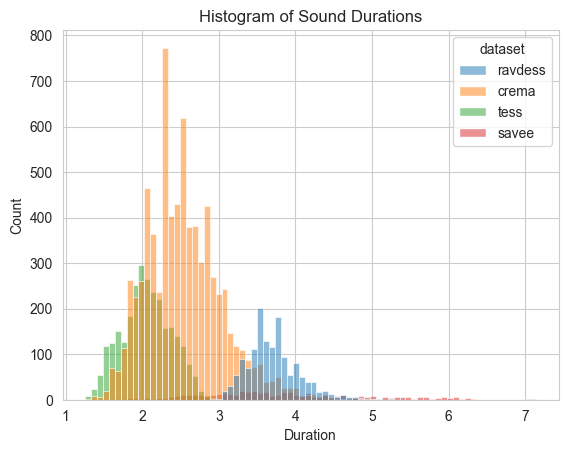

In [13]:
# Create a histogram using seaborn
sns.histplot(data=merged_df, x='duration', hue='dataset')

# Set labels and title
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Histogram of Sound Durations')

# Display the histogram
plt.show()

In [14]:
print(f"max input audion duration is {round(merged_df['duration'].max(),2)}")

max input audion duration is 7.14


The audio duration distribution of each dataset is slightly different, with the SAVEE dataset having the biggest spread.
This means that as part of the data preparation for the model, we'll need to pad the audio files with zeroes based on the longest audio files in the dataset.

## 3.2. Demonstration of various audio files

In [15]:
def play_random_audio(dataframe, gender, emotion, intensity, preprocess=False):
    # Filter the DataFrame based on the given criteria
    filtered_df = dataframe[(dataframe['genders'] == gender) & (dataframe['emotions'] == emotion) & (dataframe['audio_intensity'] == intensity)]
    
    # Randomly select an audio file path
    file_path = random.choice(np.array(filtered_df['audio_path']))
    
    # Load the audio file using librosa
    audio, sr = librosa.load(file_path)

    # Applying preprocess
    if preprocess:
        audio = preprocess_audio(audio)
        
    # Display the waveform plot
    plt.figure(figsize=(12, 4))

    # Waveform plot
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Spectrogram plot
    plt.subplot(1, 2, 2)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    img = librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel frequency')
    plt.colorbar(format='%+2.0f dB')  # A colorbar with dB format

    plt.subplots_adjust(wspace=0.4)  #  Horizontal spacing between subplots
    plt.suptitle(f'Dataset: {dataframe[dataframe["audio_path"]==file_path]["dataset"].values[0]}, Gender: {gender}, Emotion: {emotion}, Intensity: {intensity}', weight='bold', size=16)
    plt.tight_layout()

    # Play the audio
    return ipd.Audio(file_path)

Examples of random audio samples

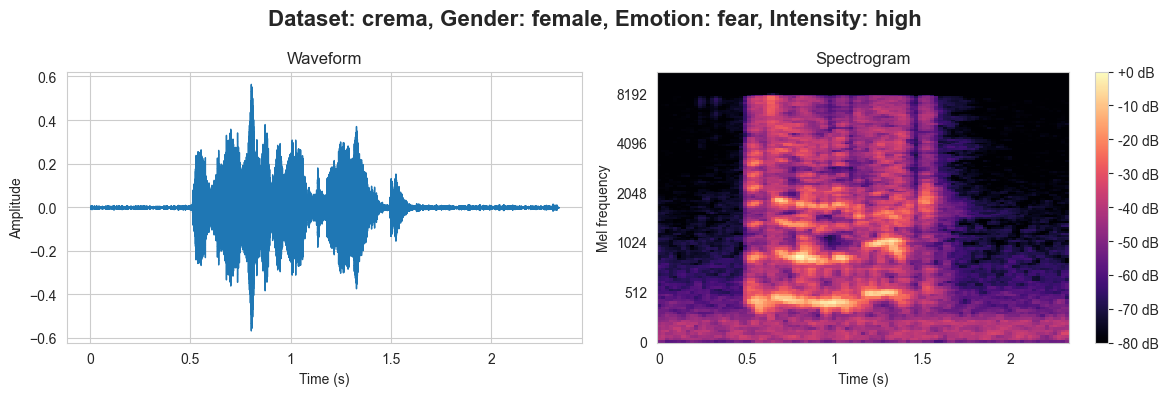

In [16]:
play_random_audio(merged_df, gender="female", emotion="fear", intensity="high")

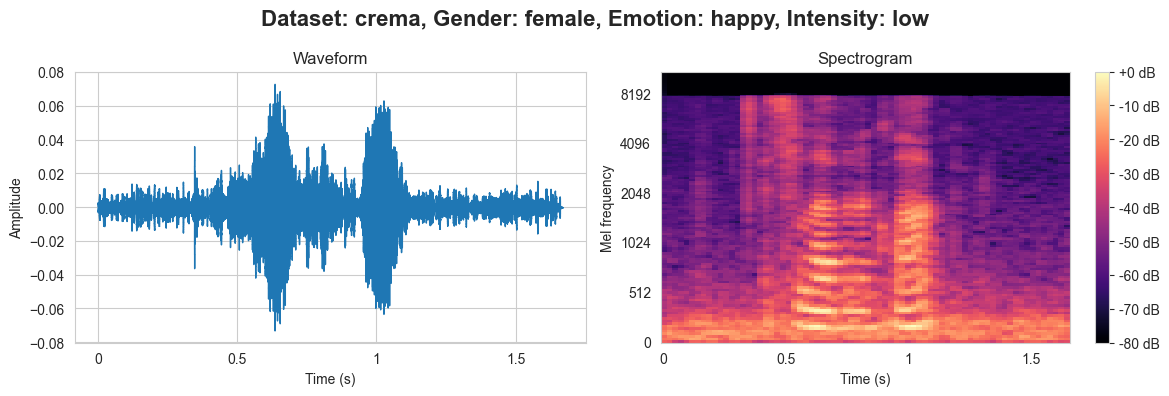

In [17]:
play_random_audio(merged_df, gender="female", emotion="happy", intensity="low")

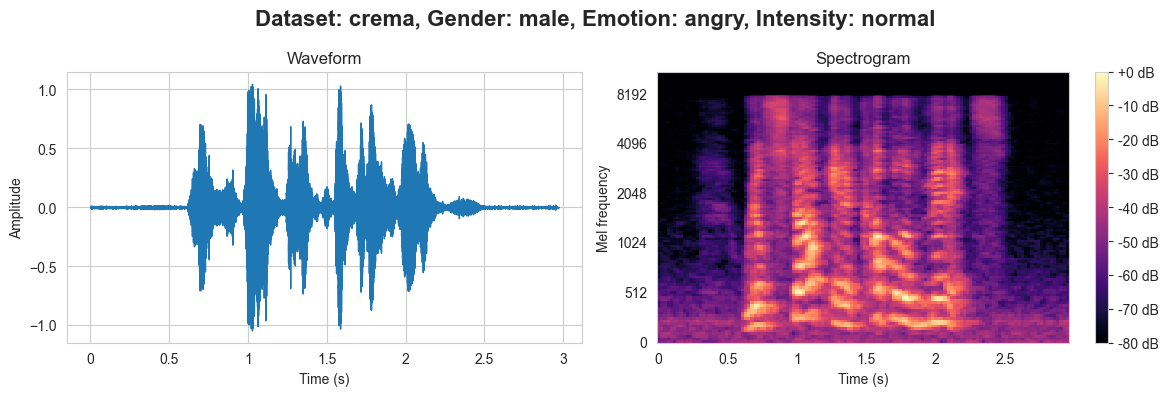

In [18]:
play_random_audio(merged_df, gender="male", emotion="angry", intensity="normal")

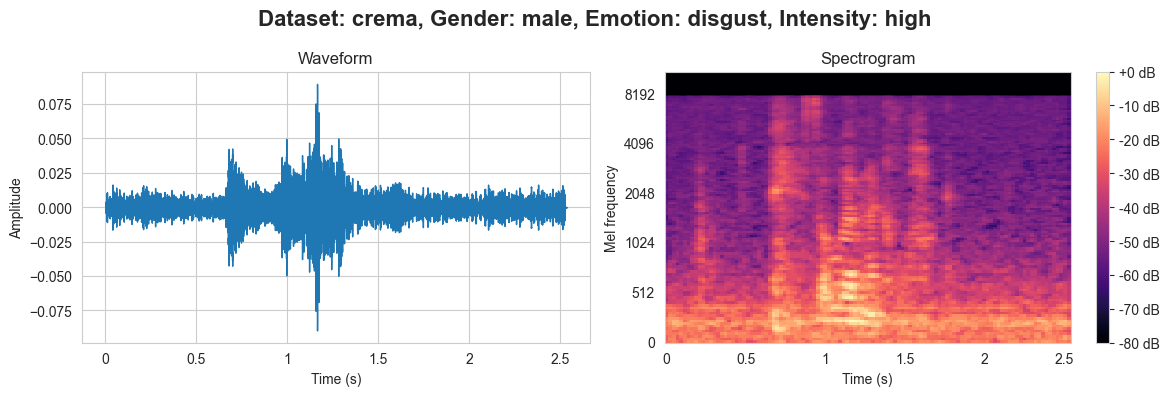

In [19]:
play_random_audio(merged_df, gender="male", emotion="disgust", intensity="high")

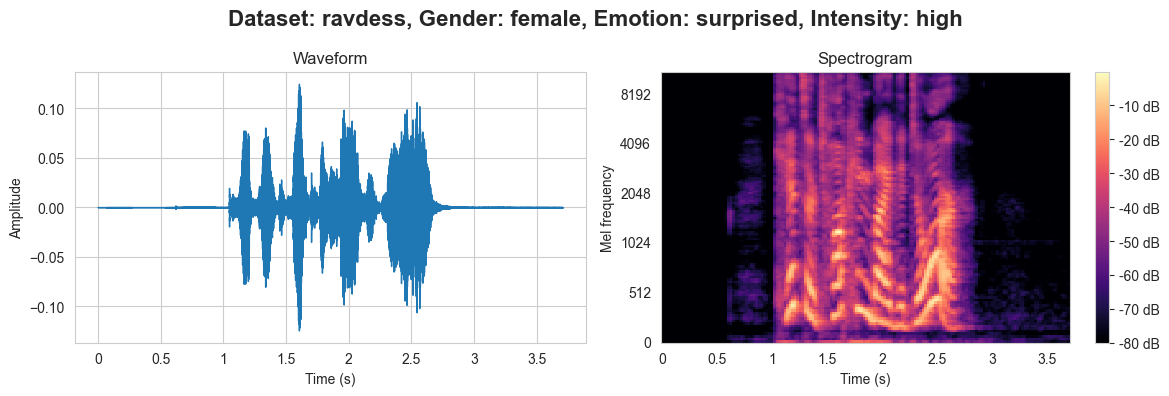

In [20]:
play_random_audio(merged_df, gender="female", emotion="surprised", intensity="high")

Each of the imported datasets originated from a different location, i.e., some with background noise, different sentences, gender of speakers, etc... <br>
This contributes to the quality of the whole data frame and thereafter to the ability of the model to classify an emotion of an unseen dataset. <br>
From the samples above, one can qualitatively distinguish between the various emotions, despite being recorded in different environments (e.g., a studio or with a sort of environmental noise) or if the speaker says a different sentence. <br>

The Mel-frequency spectrogram is designed to better approximate the perception of sound by humans, especially in terms of the frequency resolution. It captures more details in the lower frequencies where human hearing is more sensitive and provides a more perceptually relevant representation compared to the regular spectrogram with a linear frequency scale.








# 4. Feature Extraction & Preprocessing

## 4.1. Data Preprocessing

In [21]:
def preprocess_audio(audio):
    
    # waveform final samples length set to 160000 (~7.2 seconds) for SAVEE dataset compatability
    samples_count = 160000
    
    # maximum decibles considered silence to be removed from start and end of audio
    silence_db = 25
    
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=silence_db)
    padded_trimmed_audio = np.pad(trimmed_audio, (0, samples_count-len(trimmed_audio)), 'constant')
    
    return padded_trimmed_audio

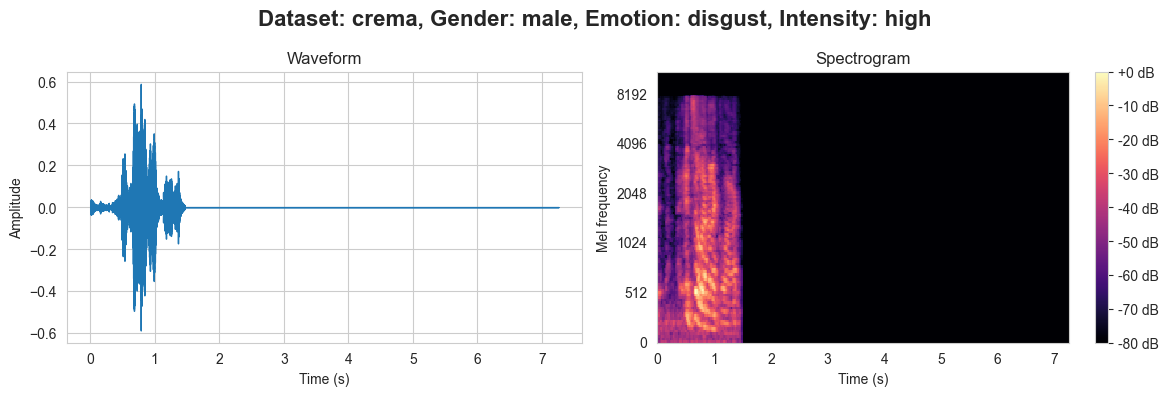

In [22]:
play_random_audio(merged_df, gender="male", emotion="disgust", intensity="high", preprocess=True)

# Baseline model

## 2D Convolution on Mel-spectrum images

In [23]:
class MFCCDataCreator:
    def __init__(self, num_mfcc=30):
        self.num_mfcc = num_mfcc
        self.max_length = 0

    def create_data(self, df):
        X = []
        y = []

        for i, row in df.iterrows():
            audio_path = row['audio_path']
            emotion = row['emotions']
            mfcc = self._extract_mfcc(audio_path)
            X.append(mfcc)
            y.append(emotion)
            # Update maximum length if needed
            if mfcc.shape[1] > self.max_length:
                self.max_length = mfcc.shape[1]

        # Apply padding or truncation with the computed maximum length
        for i in range(len(X)):
            if X[i].shape[1] < self.max_length:
                pad_width = self.max_length - X[i].shape[1]
                X[i] = np.pad(X[i], pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                X[i] = X[i][:, :self.max_length]

        X = np.array(X)
        y = np.array(y)

        return X, y, self.max_length
    
    # extract_mfcc function is an internal method
    def _extract_mfcc(self, audio_path):
        audio, sr = librosa.load(audio_path)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=self.num_mfcc)
        return mfcc

In [24]:
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history['val_' + metric]
    
    plt.plot(train_metric)
    plt.plot(val_metric)
    plt.title('Model ' + metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [25]:
def create_early_stopping_callback():
    return EarlyStopping(patience=5, monitor="val_loss", mode='min', verbose=1)

def create_model_checkpoint_callback(file_name, monitor="val_accuracy"):
    return ModelCheckpoint(file_name, save_best_only=True, monitor=monitor)

def create_reduce_lr_callback(monitor="val_accuracy"):
    return ReduceLROnPlateau(factor=0.1, patience=3, monitor=monitor, min_lr=0.00001)

In [26]:
class DataPreprocessor:
    def __init__(self, X, y, dataframe):
        self.X = X
        self.y = y
        self.dataframe = dataframe
        self.num_classes = len(dataframe['emotions'].unique())
        self.class_labels = list(dataframe['emotions'].unique())
        self.label_encoder = LabelEncoder()
    
    def split_data(self, test_size=0.2, val_size=0.1, random_state=42):
        # This methods splits the arrays after the mfcc extraction
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            self.X, self.y, test_size=test_size, shuffle=True, random_state=random_state)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size, random_state=random_state)
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def split_dataframe(self, test_size=0.2, val_size=0.1, random_state=42):
        # Splitting the data into train, val, test datasets
        train_val, test = train_test_split(self.dataframe, test_size=test_size, shuffle=True, random_state=random_state)
        train, val = train_test_split(train_val, test_size=val_size, shuffle=True, random_state=random_state)

        train = train.reset_index(drop=True)
        val = val.reset_index(drop=True)
        test = test.reset_index(drop=True)
        return train, val, test
    
    def normalize_data(self, X_train, X):
        mean = np.mean(X_train, axis=0)
        std = np.std(X_train, axis=0)
        X_scaled = (X - mean) / std
        return X_scaled
    
    def modify_channels(self, X):
        X_modified = X[..., np.newaxis]
        return X_modified
    
    def encode_labels(self, y_train, y_val, y_test):
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        y_val_encoded = self.label_encoder.transform(y_val)
        y_test_encoded = self.label_encoder.transform(y_test)
        return y_train_encoded, y_val_encoded, y_test_encoded
    
    def one_hot_encode_labels(self, y_encoded):
        y_categorical = to_categorical(y_encoded, self.num_classes, dtype='float32')
        return y_categorical
    
    def preprocess_data(self):
        X_train, X_val, X_test, y_train, y_val, y_test = self.split_data()
        X_train_scaled = self.normalize_data(X_train, X_train)
        X_val_scaled = self.normalize_data(X_train, X_val)
        X_test_scaled = self.normalize_data(X_train, X_test)
        X_train_modified = self.modify_channels(X_train_scaled)
        X_val_modified = self.modify_channels(X_val_scaled)
        X_test_modified = self.modify_channels(X_test_scaled)
        y_train_encoded, y_val_encoded, y_test_encoded = self.encode_labels(y_train, y_val, y_test)
        y_train_categorical = self.one_hot_encode_labels(y_train_encoded)
        y_val_categorical = self.one_hot_encode_labels(y_val_encoded)
        y_test_categorical = self.one_hot_encode_labels(y_test_encoded)
        
        return X_train_modified, X_val_modified, X_test_modified, y_train_categorical, y_val_categorical, y_test_categorical, self.num_classes, self.class_labels

In [27]:
class EmotionClassifier:
    def _init_(self, model, num_classes, class_labels, dataframe):
        self.model = model
        self.dataframe = dataframe
        self.num_classes = num_classes
        self.class_labels = class_labels
    
    def predict_sample(self, test):

        # Randomly choose a sample from X_test_scaled
        sample_index  = np.random.choice(self.dataframe.shape[0])
        # Get the selected sample
        sample = test[sample_index]

        prediction = self.model.predict(np.expand_dims(sample, axis=0))
        predicted_class = np.argmax(prediction)
        predicted_emotion = self.class_labels[predicted_class]
        
        # Display sample and prediction
        print("Sample Emotion:", self.dataframe.iloc[sample_index].emotions)
        print("Predicted Emotion:", predicted_emotion)
        
        # Display sound 
        audio = ipd.Audio(self.dataframe.iloc[sample_index].audio_path)
        display(audio)
        
    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print("Test Loss:", loss)
        print("Test Accuracy:", accuracy)
        
    def plot_confusion_matrix(self, X_test, y_test, class_labels):
        y_pred = self.model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)

        # Convert y_pred from label-encoded to one-hot encoded format
        y_pred_onehot = to_categorical(y_pred, self.num_classes)

        # Decode y_pred and y_test back to their original class labels
        label_encoder = LabelEncoder()
        label_encoder.fit(class_labels)
        y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_onehot, axis=1))
        y_test_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
 
        cm = confusion_matrix(y_test_labels, y_pred_labels)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Emotion")
        plt.ylabel("True Emotion")
        plt.title("Confusion Matrix")
        plt.show()

        # Calculate row sums for percentage calculation
        row_sums = cm.sum(axis=1, keepdims=True)

        # Calculate confusion matrix in percentage format
        cm_percentage = (cm / row_sums) * 100

        # Plot the confusion matrix in percentage format
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_percentage, annot=True, fmt=".0f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix (Percentage)")
        plt.show()

    def plot_metrics(self, history):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [ ]:
data_creator = MFCCDataCreator(num_mfcc=30)

In [ ]:
X, y, max_length = data_creator.create_data(merged_df)

In [ ]:
preprocessor = DataPreprocessor(X, y, merged_df)
X_train_scaled, X_val_scaled, X_test_scaled, y_train_categorical, y_val_categorical, y_test_categorical, num_classes, class_labels = preprocessor.preprocess_data()

### 3x3 kernel model

In [ ]:
input_shape = X_train_scaled.shape[1:]

# Define the optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.001)

inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_kernel3by3.h5"),
    create_reduce_lr_callback()
]

history = model.fit(X_train_scaled, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=30, 
                    validation_data=(X_val_scaled, y_val_categorical),
                    callbacks=callbacks
                    )

In [ ]:
plot_metrics(history, 'accuracy')
plot_metrics(history, 'loss')

### 4x10 kernel model

Since the MFCC shape is of a wide rectangle, a rectangular kernel might be more fitted for our model Conv2D

In [ ]:
input_shape = X_train_scaled.shape[1:]

# Define the optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.001)

inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(4, 10), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(32, kernel_size=(4, 10), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(4, 10), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(4, 10), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_kernel4by10.h5"),
    create_reduce_lr_callback()
]

history = model.fit(X_train_scaled, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=30, 
                    validation_data=(X_val_scaled, y_val_categorical),
                    callbacks=callbacks
                    )

In [ ]:
plot_metrics(history, 'accuracy')
plot_metrics(history, 'loss')

## Data Augmentation

In [ ]:
class DataAugmentation:
    def __init__(self) -> None:
        pass

    def shift_pitch(self, audio, sr, semitones):
        shifted_audio = librosa.effects.pitch_shift(audio, n_steps=float(semitones), sr=sr)
        return shifted_audio
    
    def time_shift(self, audio, sr, shift_range=5):
        shift_samples = np.random.randint(-shift_range, shift_range)*1000
        shifted_audio = np.roll(audio, shift=shift_samples)
        return shifted_audio
    
    def time_stretch(self, audio, rate):
        stretched_audio = librosa.effects.time_stretch(audio, rate=rate)
        return stretched_audio
    
    def add_noise(self, audio, noise_factor):
        noise = np.random.randn(len(audio))
        noise_factor = noise_factor *np.random.uniform() * np.amax(audio)
        noisy_audio = audio + noise_factor * noise
        return noisy_audio

In [ ]:
augmentor = DataAugmentation()

In [ ]:
merged_df.head()

In [ ]:
# Take a random 75% of the data
random_merged_df = merged_df.sample(frac=0.75, random_state=42)
random_merged_df.reset_index(drop=True, inplace=True)
random_merged_df.head()

In [ ]:
# Create a new dataframe to store augmented data
augmented_df = pd.DataFrame(columns=random_merged_df.columns)

In [ ]:
# Set output folder to save augmented audio files
output_folder = './data/augmented_audio'  

In [ ]:
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
for idx, row in random_merged_df.iterrows():
    audio_path = row['audio_path']
    emotion = row['emotions']
    
    # Load the audio
    audio, sr = librosa.load(audio_path, sr=None)
    
    # Augment the audio using each method in the DataAugmentation class
    shifted_audio = augmentor.shift_pitch(audio, sr, semitones=2)
    time_shifted_audio = augmentor.time_shift(audio, sr, shift_range=5)
    stretched_audio = augmentor.time_stretch(audio, rate=1.2)
    noisy_audio = augmentor.add_noise(audio, noise_factor=0.1)
    
    # Save the augmented audio if needed
    output_path = os.path.join(output_folder, f'{emotion}_{idx}.wav')
    sf.write(output_path, shifted_audio, sr)
    
    # Append the augmented data to the augmented_df
    augmented_df = pd.concat([augmented_df, 
                              pd.DataFrame([{
                                  'emotions': emotion,
                                  'genders': row['genders'],
                                  'audio_intensity': row['audio_intensity'],
                                  'audio_path': output_path,  # Replace with the actual path if not saving
                                  'duration': row['duration'],
                                  'dataset': row['dataset']
                              }])])

augmented_df.to_csv('augmented_df.csv',index=False)

In [ ]:
merged_df = pd.read_csv('merged_df.csv')
augmented_df = pd.read_csv('augmented_df.csv')

In [ ]:
final_data = pd.concat([merged_df, augmented_df], axis=0)

In [ ]:
final_data.shape

In [ ]:
data_creator = MFCCDataCreator(num_mfcc=40)

In [ ]:
sns.histplot(data=final_data, x='duration', hue='dataset')

In [ ]:
final_data.head()

In [ ]:
X, y, max_length = data_creator.create_data(final_data)

In [ ]:
preprocessor = DataPreprocessor(X, y, final_data)
X_train_scaled, X_val_scaled, X_test_scaled, y_train_categorical, y_val_categorical, y_test_categorical, num_classes, class_labels = preprocessor.preprocess_data()

In [ ]:
# Splitting the data into train , val, test datasets
_, _, test = preprocessor.split_dataframe()

In [ ]:
input_shape = X_train_scaled.shape[1:]

# Define the optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.001)

inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_kernel3by3_augmentation.h5"),
    create_reduce_lr_callback()
]

In [ ]:
history = model.fit(X_train_scaled, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=50, 
                    validation_data=(X_val_scaled, y_val_categorical),
                    callbacks=callbacks
                    )

In [ ]:
emotion_classifier = EmotionClassifier(model, num_classes, class_labels, test)

In [ ]:
emotion_classifier.predict_sample(X_test_scaled)

In [ ]:
emotion_classifier.evaluate(X_test_scaled, y_test_categorical)

In [ ]:
emotion_classifier.plot_confusion_matrix(X_test_scaled, y_test_categorical, class_labels)

In [ ]:
emotion_classifier.plot_metrics(history)

## LSTM features Model

In [28]:
class AudioFeatureExtractor:
    def __init__(self, df, frame_length=2048, hop_length=512):
        self.frame_length = frame_length
        self.hop_length = hop_length
        self.df = df

    def features_extraction(self, preprocess=True, trim=True, pad=True, extended=False):
        zcr_list = []
        mfccs_list = []
        emotion_list = []

        if extended:
            rms_list = []
            spectral_centroid_list = []
            spectral_rolloff_list = []
            melspectrogram_list = []
            chroma_stft_list = []
        
        for row in self.df.itertuples(index=False):
            audio, sr = librosa.load(row.audio_path)

            if preprocess:
                audio = self.preprocess_audio(audio, trim, pad)
    
            zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=self.frame_length, hop_length=self.hop_length)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=30, hop_length=self.hop_length)

            zcr_list.append(zcr)
            mfccs_list.append(mfccs)
            emotion_list.append(row.emotions)

            if extended:
                spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=self.hop_length)
                spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, hop_length=self.hop_length)
                melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, hop_length=self.hop_length)
                chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=self.hop_length)
                rms = librosa.feature.rms(y=audio, frame_length=self.frame_length, hop_length=self.hop_length)
                
                rms_list.append(rms)
                spectral_centroid_list.append(spectral_centroid)
                spectral_rolloff_list.append(spectral_rolloff)
                melspectrogram_list.append(melspectrogram)
                chroma_stft_list.append(chroma_stft)

        if extended:
            return zcr_list, mfccs_list, rms_list, spectral_centroid_list, spectral_rolloff_list, melspectrogram_list, chroma_stft_list, emotion_list
    
        return zcr_list, mfccs_list, emotion_list

    def create_arrays_data(self, preprocess=True):
        zcr_list, mfccs_list, emotion_list = self.features_extraction()

        X = np.concatenate((
            np.swapaxes(zcr_list, 1, 2), 
            np.swapaxes(mfccs_list, 1, 2)), 
            axis=2
        )
        X = X.astype('float32')
        y = np.asarray(emotion_list)
        df = pd.DataFrame({'emotions':emotion_list, 'zcr':zcr_list, 'mfccs': mfccs_list})
            
        return X, y, df

    def create_means_data(self, preprocess=True):
        data = self.features_extraction(pad=False, extended=True)
        zcr_means = [np.mean(array) for array in data[0]]
        mfcc_means = [np.mean(array) for array in data[1]]
        rms_means = [np.mean(array) for array in data[2]]
        spectral_centroid_means = [np.mean(array) for array in data[3]]
        spectral_rolloff_means = [np.mean(array) for array in data[4]]
        melspectrogram_means = [np.mean(array) for array in data[5]]
        chroma_stft_means = [np.mean(array) for array in data[6]]

        emotions_list = data[7]
        
        X = np.array([zcr_means, mfcc_means, rms_means, spectral_centroid_means, spectral_rolloff_means, melspectrogram_means, chroma_stft_means])
        X = np.swapaxes(X, 0, 1)
        X = X.astype('float32')
        X = X.reshape(X.shape[0], X.shape[1], 1)

        y = np.asarray(emotions_list)

        df = pd.DataFrame({'emotions':emotions_list, 'zcr_mean':zcr_means, 'mfccs_mean': mfcc_means, 'rms_mean':rms_means, 'spectral_centroid_mean':spectral_centroid_means,
                           'spectral_rolloff_mean':spectral_rolloff_means, 'melspectrogram_mean':melspectrogram_means, 'chroma_stft_mean':chroma_stft_means})

        return X, y, df
    
    def preprocess_audio(self, audio, trim =True, pad = True, samples_count=160000, silence_db=25):
        if trim:
            audio = self.trim_audio(audio, silence_db)
        if pad:
            audio = self.pad_audio(audio, samples_count)
        return audio

    def trim_audio(self, audio, silence_db):
        trimmed_audio, _ = librosa.effects.trim(audio, top_db=silence_db)
        return trimmed_audio

    def pad_audio(self, audio, samples_count):
        padded_audio = np.pad(audio, (0, samples_count-len(audio)), 'constant')
        return padded_audio

In [63]:
feature_extractor = AudioFeatureExtractor(merged_df)

In [64]:
X, y, df = feature_extractor.create_arrays_data()

In [65]:
df.head()

,emotions,zcr,mfccs
0,neutral,"[[0.1806640625, 0.2666015625, 0.29150390625, 0...","[[-673.8612, -500.93295, -463.58884, -424.6362..."
1,neutral,"[[0.15283203125, 0.16015625, 0.1689453125, 0.0...","[[-518.0421, -479.19376, -434.56332, -396.5498..."
2,neutral,"[[0.16796875, 0.1787109375, 0.19140625, 0.0810...","[[-735.57513, -508.27155, -425.2889, -399.9355..."
3,neutral,"[[0.1611328125, 0.1708984375, 0.18408203125, 0...","[[-638.9588, -446.9245, -372.6338, -361.95847,..."
4,neutral,"[[0.16943359375, 0.255859375, 0.32275390625, 0...","[[-558.5768, -503.0021, -505.46335, -512.21625..."


In [66]:
preprocessor = DataPreprocessor(X, y, df)

In [67]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data()

In [68]:
y_train_encoded, y_val_encoded, y_test_encoded = preprocessor.encode_labels(y_train, y_val, y_test)

In [69]:
y_train_categorical = preprocessor.one_hot_encode_labels(y_train_encoded)
y_val_categorical = preprocessor.one_hot_encode_labels(y_val_encoded)
y_test_categorical = preprocessor.one_hot_encode_labels(y_test_encoded)

In [62]:
X_train

array([[[-0.33627656],
        [ 0.65178776],
        [-0.35026824],
        ...,
        [-0.6742629 ],
        [-0.2819368 ],
        [ 0.7273947 ]],

       [[-0.7899649 ],
        [ 0.59008104],
        [-0.43763247],
        ...,
        [-0.70140344],
        [-0.30115554],
        [ 0.31608045]],

       [[ 1.0667269 ],
        [-2.3405538 ],
        [-0.4377292 ],
        ...,
        [ 1.5611566 ],
        [-0.31915262],
        [-0.649485  ]],

       ...,

       [[-0.44851655],
        [ 0.82694197],
        [ 2.0883627 ],
        ...,
        [-0.6175827 ],
        [ 1.5709436 ],
        [-0.97337574]],

       [[ 0.4913996 ],
        [ 1.0965874 ],
        [ 2.029868  ],
        ...,
        [ 0.6816064 ],
        [ 1.4543031 ],
        [-1.3235835 ]],

       [[-0.8415988 ],
        [ 0.273158  ],
        [-0.69153136],
        ...,
        [-0.32935968],
        [-0.34275645],
        [ 1.2835822 ]]], dtype=float32)

In [70]:
model = Sequential()

model.add(LSTM(256, return_sequences=True, input_shape=(X.shape[1:3])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 313, 256)          294912    
                                                                 
 dropout_9 (Dropout)         (None, 313, 256)          0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 7)                

In [71]:
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_lstm64.h5", monitor='val_categorical_accuracy'),
    create_reduce_lr_callback(monitor='val_categorical_accuracy')
]

history = model.fit(X_train, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs= 50, 
                    validation_data=(X_val, y_val_categorical),
                    callbacks=callbacks
                    )

Epoch 1/50
274/274 [==============================] - 209s 752ms/step - loss: 1.6819 - categorical_accuracy: 0.3064 - val_loss: 1.4807 - val_categorical_accuracy: 0.4203 - lr: 0.0100
Epoch 2/50
274/274 [==============================] - 192s 699ms/step - loss: 1.4745 - categorical_accuracy: 0.4082 - val_loss: 1.3919 - val_categorical_accuracy: 0.4738 - lr: 0.0100
Epoch 3/50
274/274 [==============================] - 202s 737ms/step - loss: 1.3866 - categorical_accuracy: 0.4571 - val_loss: 1.3391 - val_categorical_accuracy: 0.4995 - lr: 0.0100
Epoch 4/50
274/274 [==============================] - 211s 768ms/step - loss: 1.3234 - categorical_accuracy: 0.4790 - val_loss: 1.2740 - val_categorical_accuracy: 0.5242 - lr: 0.0100
Epoch 5/50
274/274 [==============================] - 216s 788ms/step - loss: 1.2572 - categorical_accuracy: 0.5059 - val_loss: 1.2261 - val_categorical_accuracy: 0.5488 - lr: 0.0100
Epoch 6/50
274/274 [==============================] - 222s 810ms/step - loss: 1.2381 

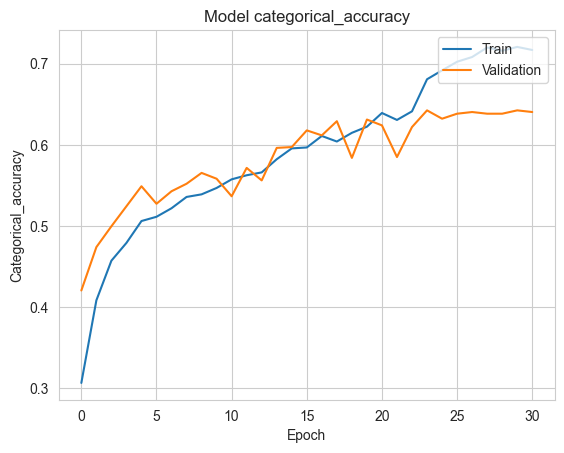

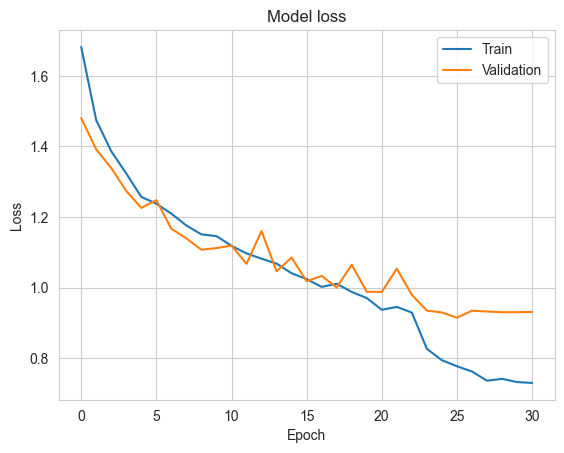

In [72]:
plot_metrics(history, 'categorical_accuracy')
plot_metrics(history, 'loss')

In [73]:
merged_df = pd.read_csv('merged_df.csv')
augmented_df = pd.read_csv('augmented_df.csv')

In [74]:
final_data = pd.concat([merged_df, augmented_df], axis=0)

In [75]:
feature_extractor = AudioFeatureExtractor(final_data)

In [76]:
X, y, df = feature_extractor.create_arrays_data()

In [77]:
preprocessor = DataPreprocessor(X, y, df)

In [78]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data()

In [79]:
y_train_encoded, y_val_encoded, y_test_encoded = preprocessor.encode_labels(y_train, y_val, y_test)

In [80]:
y_train_categorical = preprocessor.one_hot_encode_labels(y_train_encoded)
y_val_categorical = preprocessor.one_hot_encode_labels(y_val_encoded)
y_test_categorical = preprocessor.one_hot_encode_labels(y_test_encoded)

In [81]:
model = Sequential()

model.add(LSTM(256, return_sequences=True, input_shape=(X.shape[1:3])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 313, 256)          294912    
                                                                 
 dropout_12 (Dropout)        (None, 313, 256)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 7)                

In [82]:
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_lstm64_augumentation.h5", monitor='val_categorical_accuracy'),
    create_reduce_lr_callback(monitor='val_categorical_accuracy')
]

history = model.fit(X_train, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=50, 
                    validation_data=(X_val, y_val_categorical),
                    callbacks=callbacks
                    )

Epoch 1/50
479/479 [==============================] - 378s 784ms/step - loss: 1.6120 - categorical_accuracy: 0.3235 - val_loss: 1.4561 - val_categorical_accuracy: 0.4099 - lr: 0.0100
Epoch 2/50
479/479 [==============================] - 358s 747ms/step - loss: 1.4103 - categorical_accuracy: 0.4244 - val_loss: 1.3307 - val_categorical_accuracy: 0.4416 - lr: 0.0100
Epoch 3/50
479/479 [==============================] - 364s 760ms/step - loss: 1.2977 - categorical_accuracy: 0.4838 - val_loss: 1.2893 - val_categorical_accuracy: 0.4750 - lr: 0.0100
Epoch 4/50
479/479 [==============================] - 367s 766ms/step - loss: 1.2429 - categorical_accuracy: 0.5028 - val_loss: 1.1958 - val_categorical_accuracy: 0.5097 - lr: 0.0100
Epoch 5/50
479/479 [==============================] - 384s 801ms/step - loss: 1.2194 - categorical_accuracy: 0.5085 - val_loss: 1.1978 - val_categorical_accuracy: 0.5203 - lr: 0.0100
Epoch 6/50
479/479 [==============================] - 383s 800ms/step - loss: 1.1903 

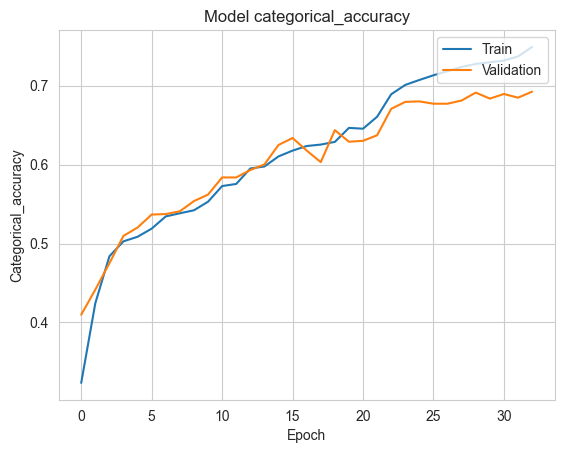

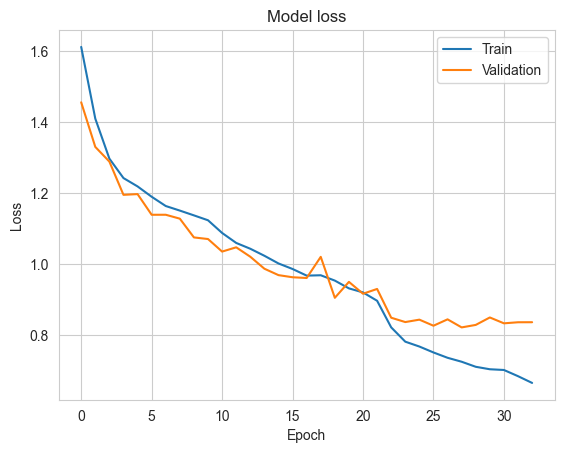

In [83]:
plot_metrics(history, 'categorical_accuracy')
plot_metrics(history, 'loss')

## Tabular features means Model

### Tabular Features Means Model Conv1D

In [27]:
feature_extractor = AudioFeatureExtractor(merged_df)

In [28]:
X, y, df = feature_extractor.create_means_data()

In [48]:
preprocessor = DataPreprocessor(X, y, df)

In [49]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data()

In [50]:
y_train_encoded, y_val_encoded, y_test_encoded = preprocessor.encode_labels(y_train, y_val, y_test)

In [51]:
y_train_categorical = preprocessor.one_hot_encode_labels(y_train_encoded)
y_val_categorical = preprocessor.one_hot_encode_labels(y_val_encoded)
y_test_categorical = preprocessor.one_hot_encode_labels(y_test_encoded)

In [56]:
X_train = preprocessor.normalize_data(X_train, X_train)
X_val = preprocessor.normalize_data(X_train, X_val)

In [57]:
X_train.shape, y_train_categorical.shape, X_val.shape, y_val_categorical.shape

((8756, 7, 1), (8756, 7), (973, 7, 1), (973, 7))

In [60]:
model=Sequential()

model.add(Conv1D(16, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = Adam(learning_rate=0.01) , loss = 'categorical_crossentropy' , metrics = ['categorical_accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 7, 16)             96        
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 4, 16)             0         
 ng1D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 4, 16)             0         
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 7)                 455       
                                                                 
Total params: 551 (2.15 KB)
Trainable params: 551 (2.15 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [61]:
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_conv1d.h5", monitor='val_categorical_accuracy'),
    create_reduce_lr_callback(monitor='val_categorical_accuracy')
]

history = model.fit(X_train, 
                    y_train_categorical, 
                    batch_size=6, 
                    epochs=50, 
                    validation_data=(X_val, y_val_categorical),
                    callbacks=callbacks
                    )

Epoch 1/50
1460/1460 [==============================] - 2s 1ms/step - loss: 1.7412 - categorical_accuracy: 0.2884 - val_loss: 2016.1874 - val_categorical_accuracy: 0.1562 - lr: 0.0100
Epoch 2/50
1460/1460 [==============================] - 1s 977us/step - loss: 1.7042 - categorical_accuracy: 0.3013 - val_loss: 3881.2114 - val_categorical_accuracy: 0.1439 - lr: 0.0100
Epoch 3/50
1460/1460 [==============================] - 2s 1ms/step - loss: 1.7043 - categorical_accuracy: 0.3028 - val_loss: 3743.5654 - val_categorical_accuracy: 0.1069 - lr: 0.0100
Epoch 4/50
1460/1460 [==============================] - 1s 720us/step - loss: 1.6957 - categorical_accuracy: 0.3087 - val_loss: 4984.1870 - val_categorical_accuracy: 0.1439 - lr: 0.0100
Epoch 5/50
1460/1460 [==============================] - 2s 1ms/step - loss: 1.6554 - categorical_accuracy: 0.3336 - val_loss: 5295.5400 - val_categorical_accuracy: 0.1439 - lr: 1.0000e-03
Epoch 6/50
1460/1460 [==============================] - 2s 1ms/step - lo

### Tabular Features Means Model Classification

In [71]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score,f1_score,fbeta_score, make_scorer

from sklearn import set_config
set_config(transform_output="pandas")

In [163]:
# Define the models to evaluate
models = [
    {
        'name': 'Random Forest Classifier',
        'model': RandomForestClassifier(random_state=42, oob_score=True),
        'param_grid': {'n_estimators': [500, 750, 1000],
                       'max_depth': [5, 15, 25],
                       'min_samples_split': [2, 8, 14],
                       'min_samples_leaf': [1, 5, 10],
                       }
    },
    {
        'name': 'XGBoost Classifier',
        'model': XGBClassifier(random_state=42),
        'param_grid': {'n_estimators': [100, 300, 500],
                       'max_depth': [2, 3, 5],
                       'min_child_weight': [1, 5, 10],
                       'eta': [0.1, 0.3, 0.5],
                       'gamma': [0.1, 0.3, 0.5],
                       'learning_rate': [0.1, 0.2, 0.3],
                       }
    },
    #{
    #    'name': 'LightGBM Classifier',
    #    'model': LGBMClassifier(random_state=42),
    #    'param_grid': {'n_estimators': [100, 300, 500],
    #                   'max_depth': [2, 3, 5],
    #                   'min_child_weight': [1, 5, 10],
    #                   'learning_rate': [0.1, 0.2, 0.3],
    #                   'objective': ['multiclass'], 
    #                   'num_class':[7], 
    #                   'metric': ['multi_logloss'], 
    #                   }
    #},
    #{
    #    'name': 'Logistic Regression',
    #    'model': LogisticRegression(),
    #    'param_grid': {}
    #},
]

In [148]:
class ModelEvaluator:
    def __init__(self, models):
        self.models = models
        self.best_models = {}
        self.predictions = {}
        self.predictions_proba = {}  # Initialize an empty dictionary for predicted probabilities
        self.columns = None  # Store the column names of X_train
        self.feature_importance = {}

    def fit(self, X_train, y_train, n_iter=1, cv=2):
      self.columns = X_train.columns  # Store the column names  

      # Perform random search CV for each model
      for model_info in self.models:
        model_name = model_info['name']
        model = model_info['model']
        param_grid = model_info['param_grid']
        print(f'Performing fit for {model_name}')
        # Create a RandomizedSearchCV object
        random_search = RandomizedSearchCV(model, param_grid, scoring=make_scorer(f1_score, average='macro'), n_iter=n_iter, cv=cv, random_state=42, verbose=10, error_score='raise')

        # Fit the model with training dat
        random_search.fit(X_train, y_train)

        # Get the best model and its hyperparameters
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        # Store the best model
        self.best_models[model_name] = best_model

        # Store the feature importance
        if hasattr(best_model, 'feature_importances_'):
            self.feature_importance[model_name] = best_model.feature_importances_

    def fit_best_model(self, model_name, X_train_new, y_train_new):
      if model_name in self.best_models:
        best_model = self.best_models[model_name]
        best_params = best_model.get_params()
        fitted_model = clone(best_model)  # Create a copy of the best model
        fitted_model.set_params(**best_params)  # Set the best parameters to the copy
        fitted_model.fit(X_train_new, y_train_new)  # Fit the copy with the new data
        self.best_models[model_name] = fitted_model  # Update the best model with the fitted copy
      else:
        print(f"No best model found with name: {model_name}")
        

    def predict(self, X_test, threshold=0.5):
      # Generate predictions for each model
      for model_name, best_model in self.best_models.items():
        # Make predictions on test data
        # y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]

        # Create an empty array to store the predicted labels
        y_pred = np.zeros_like(y_pred_proba)

        # Assign class labels based on the threshold
        y_pred[y_pred_proba >= threshold] = 1      
        
        # Store the predictions
        self.predictions[model_name] = y_pred
        self.predictions_proba[model_name] = y_pred_proba
      return self.predictions, self.predictions_proba[model_name]

    def evaluate_metrics(self, y_true, y_pred, y_pred_proba):
      # Calculate evaluation metrics
      confusion = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize='true')
      roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
      fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

      # calculate precision and recall
      precision = precision_score(y_true, y_pred)
      recall = recall_score(y_true, y_pred)
      f1 = f1_score(y_true, y_pred)
      fbeta = fbeta_score(y_true, y_pred, beta=1.5)

      # Return the evaluation metrics
      return confusion, roc_auc, fpr, tpr, thresholds, precision, recall, f1, fbeta

    def best_models_comparison(self, y_test):
      scoring_dict = {}
      for model_name, y_pred in self.predictions.items():
        y_true = y_test  # Replace y_test with your test labels
        y_pred_proba = self.predictions_proba[model_name]  # Retrieve the predicted probabilities
        confusion, roc_auc, fpr, tpr, thresholds, precision, recall, f1, fbeta = self.evaluate_metrics(y_true, y_pred, y_pred_proba)
        scoring_dict[model_name] = {'roc_auc':roc_auc,'precision':precision,'recall':recall,'f1':f1, 'fbeta':fbeta,
                                    'true_negative':confusion[0][0],'false_negative':confusion[0][1],
                                    'false_positive':confusion[1][0],'true_positive':confusion[1][1]}
      return scoring_dict

    def visualize_results(self, y_test):
      # Create a single figure for ROC curve
      plt.figure(figsize=(10, 6))
      plt.title('Receiver Operating Characteristic', fontsize=16, fontweight='bold')
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
      plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')

      # Initialize the confusion matrix figure
      fig, axes = plt.subplots(nrows=len(self.models), figsize=(8, 4 * len(self.models)))
      fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing

      # Plot ROC curve for each model
      for i, (model_name, y_pred) in enumerate(self.predictions.items()):
        y_true = y_test  # Replace y_test with your test labels
        y_pred_proba = self.predictions_proba[model_name]  # Retrieve the predicted probabilities
        confusion, roc_auc, fpr, tpr, thresholds, precision, recall, f1, fbeta = self.evaluate_metrics(y_true, y_pred, y_pred_proba)     
        
        # Plot confusion matrix as a heatmap
        if len(self.models) > 1:
          ax = axes[i]
        else:
          ax = axes
        plt.figure(figsize=(8,6))
        ax.set_title(f'Confusion Matrix - {model_name} (Precision={precision:.2f}, Recall={recall:.2f}, f1={f1:.2f})', fontsize=16, fontweight='bold')
        sns.heatmap(confusion, annot=True, fmt='.2f', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted', fontsize=14, fontweight='bold')
        ax.set_ylabel('Actual', fontsize=14, fontweight='bold')

        # Plot ROC curve
        plt.figure(1)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f}')

      # Show the ROC curve
      plt.legend(loc="lower right")
      plt.show()

      # Show the confusion matrix figures
      fig.tight_layout()
      plt.show()

    def plot_feature_importance(self, top_n=20):
      if not self.feature_importance:
        print("Feature importances not available for any model.")
        return

      # Plot feature importances for each model
      for model_name, feature_importance in self.feature_importance.items():
          # Create a DataFrame for feature importances
          importance_df = pd.DataFrame({'Feature': self.columns, 'Importance': feature_importance})

          # Sort the DataFrame by importance values
          importance_df = importance_df.sort_values(by='Importance', ascending=False)

          # Select the top N features
          top_features = importance_df.head(top_n)

          # Create a color palette with shades of blue
          num_colors = len(top_features)
          colors = sns.cubehelix_palette(num_colors, start=2, rot=0, dark=0.2, light=0.8)

          # Plot the feature importances on horizontal barplot
          plt.figure(figsize=(10, 6))
          sns.barplot(x='Importance', y='Feature', data=top_features, palette=colors, orient='h')
          plt.title(f'Top {top_n} Feature Importances - {model_name}')
          plt.xlabel('Importance')
          plt.ylabel('Feature')
          plt.show()

In [30]:
feature_extractor = AudioFeatureExtractor(merged_df)

In [31]:
_, _, df = feature_extractor.create_means_data()

In [149]:
df = df.sample(frac=1).reset_index(drop=True)

In [150]:
X = df.drop(['emotions'], axis=1)
y = df['emotions']

In [151]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [152]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

In [153]:
MMS = MinMaxScaler()

In [154]:
X_train_scaled = MMS.fit_transform(X_train)
X_val_scaled = MMS.transform(X_val)

In [155]:
LE = LabelEncoder()

In [156]:
y_train_encoded = LE.fit_transform(y_train)
y_val_encoded = LE.transform(y_val)

In [157]:
y_train_encoded_onehot = to_categorical(y_train_encoded)
y_val_encoded_onehot = to_categorical(y_val_encoded)

In [164]:
evaluator = ModelEvaluator(models)

In [165]:
evaluator.fit(X_train_scaled, y_train_encoded_onehot, n_iter=10, cv=4)

Performing fit for Random Forest Classifier
Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4; 1/10] START max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=500
[CV 1/4; 1/10] END max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=500;, score=0.351 total time=  10.8s
[CV 2/4; 1/10] START max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=500
[CV 2/4; 1/10] END max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=500;, score=0.373 total time=  11.0s
[CV 3/4; 1/10] START max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=500
[CV 3/4; 1/10] END max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=500;, score=0.356 total time=  11.1s
[CV 4/4; 1/10] START max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=500
[CV 4/4; 1/10] END max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=500;, score=0.346 total time=  11.2s
[CV 1/4; 2/10] START max_de

(1946, 2)
(7,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

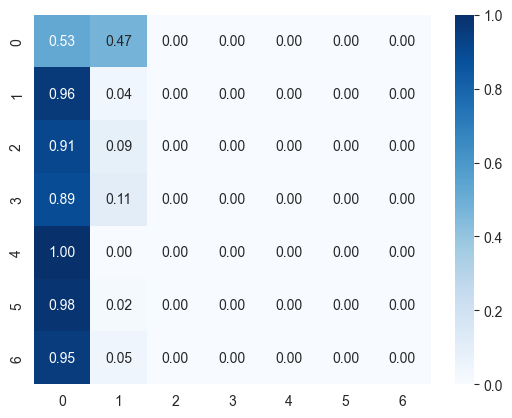

In [183]:
predictions = {}
predictions_proba = {}

for model_name, best_model in evaluator.best_models.items():
    y_pred_proba = best_model.predict_proba(X_val_scaled)[0]
    print(y_pred_proba.shape)
    y_pred_proba_cut = y_pred_proba[:, 1]
    y_pred = np.zeros_like(y_pred_proba)
    y_pred[y_pred_proba >= 0.5] = 1
    predictions[model_name] = y_pred
    predictions_proba[model_name] = y_pred_proba
    sns.heatmap(confusion_matrix(y_true=y_val_encoded_onehot.argmax(axis=1), y_pred=y_pred.astype(int).argmax(axis=1), normalize='true'), annot=True, fmt='.2f', cmap='Blues')

## Transfer learning
